# Frequency Domain Solver
Meep 的frequency-domain solver頻域求解器 用於計算響應連續波continuous-wave源而產生的場 
此示例涉及使用頻域求解器來計算描述的ring resonator環形諧振器的場  
我們將驗證域中的誤差隨著iterative solver疊代求解器容差的減小而monotonically單調減小  
使用不同方法計算的頻域場的定性一致性：傅立葉變換時域場以響應窄帶高斯脈衝源  

頻域求解器的使用只涉及對original simulation的兩個更改  
用連續源替換脈衝源  打開complex fields 因為默認使用實場  

可以做一些事情來提高其convergence properties收斂性  
對 CW 源使用non-zero smoothing width（默認為 0）以減少由其突然開啟產生的高頻率振盪(具有較慢的群速度並且被 PML 吸收不良)  
將 BiCGSTAB-L 迭代求解器的 L 參數從默認的 2 增加到 10

In [1]:
import meep as mp
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt

     cylinder, center = (0,0,0)
          radius 2, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (11.56,11.56,11.56)
     cylinder, center = (0,0,0)
          radius 1, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)


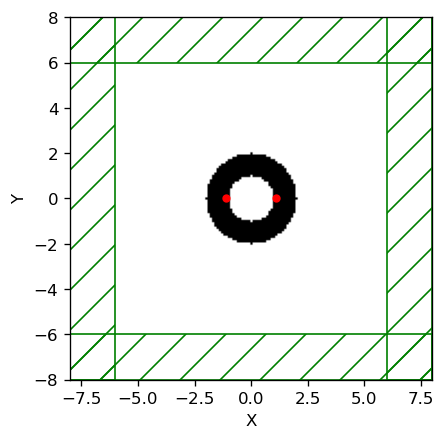

In [8]:
n = 3.4
w = 1
r = 1
pad = 4
dpml = 2

sxy = 2*(r+w+pad+dpml)
cell_size = mp.Vector3(sxy,sxy)

pml_layers = [mp.PML(dpml)]

nonpml_vol = mp.Volume(mp.Vector3(), size=mp.Vector3(sxy-2*dpml,sxy-2*dpml))

geometry = [mp.Cylinder(radius=r+w, material=mp.Medium(index=n)),
            mp.Cylinder(radius=r)]

fcen = 0.118

src = [mp.Source(mp.ContinuousSource(fcen),#單一頻率
                 component=mp.Ez,
                 center=mp.Vector3(r+0.1)),
       mp.Source(mp.ContinuousSource(fcen),
                 component=mp.Ez,
                 center=mp.Vector3(-(r+0.1)),
                 amplitude=-1)]

symmetries = [mp.Mirror(mp.X,phase=-1),
              mp.Mirror(mp.Y,phase=+1)]

sim = mp.Simulation(cell_size=cell_size,
                    geometry=geometry,
                    sources=src,
                    resolution=10,
                    force_complex_fields=True,
                    symmetries=symmetries,
                    boundary_layers=pml_layers)
f = plt.figure(dpi=120)
sim.plot2D(ax=f.gca())
plt.show()

In [3]:
num_tols = 5
tols = np.power(10, np.arange(-8.0,-8.0-num_tols,-1.0))
ez_dat = np.zeros((122,122,num_tols), dtype=np.complex_)

for i in range(num_tols):
    sim.init_sim()
    sim.solve_cw(tols[i], 10000, 15) #可容許誤差，，花多少資源
    ez_dat[:,:,i] = sim.get_array(vol=nonpml_vol, component=mp.Ez)

-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.0014379 s
Working in 2D dimensions.
Computational cell is 16 x 16 x 0 with resolution 10
     cylinder, center = (0,0,0)
          radius 2, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (11.56,11.56,11.56)
     cylinder, center = (0,0,0)
          radius 1, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.016294 s
-----------
Meep: using complex fields.
on time step 2135 (time=106.75), 0.00187361 s/step
residual[73] = 0.000521241
final residual = 9.90806e-09
Finished solve_cw after 102 CG iters (~ 3060 timesteps).
residual[67] = 0.000251664
on time step 1982 (time=99.1), 0.0020232 s/step
final residual = 5.41777e-10
Finished solve_cw after 102 CG iters (~ 3060 timesteps).
residual[71] = 0.00028596
on time step 2102 (time=105.1), 0.00

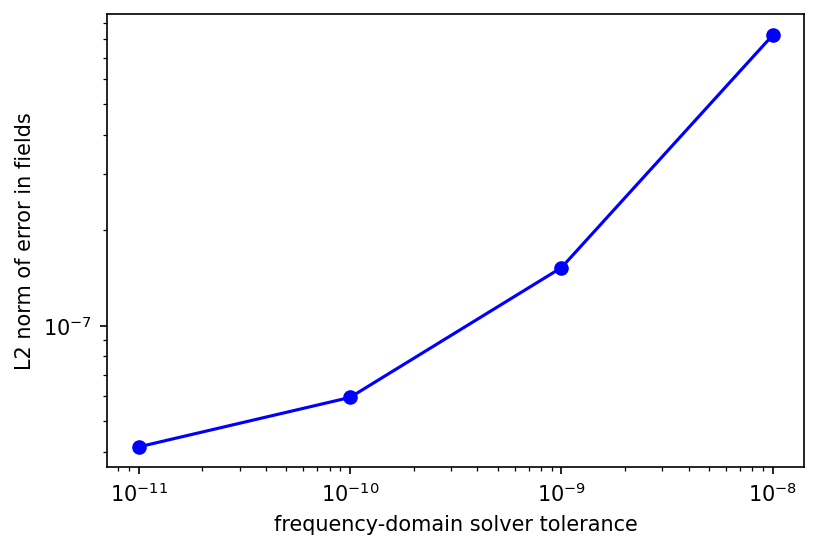

In [4]:
err_dat = np.zeros(num_tols-1)
for i in range(num_tols-1):
    err_dat[i] = LA.norm(ez_dat[:,:,i]-ez_dat[:,:,num_tols-1]) # 算出的減掉最大tourance 

plt.figure(dpi=150)
plt.loglog(tols[:num_tols-1], err_dat, 'bo-');
plt.xlabel("frequency-domain solver tolerance");
plt.ylabel("L2 norm of error in fields");
plt.show()

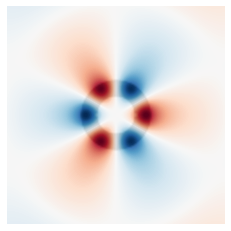

PASSED solve_cw test: error in the fields is decreasing with increasing resolution


In [5]:
eps_data = sim.get_array(vol=nonpml_vol, component=mp.Dielectric)
ez_data = np.real(ez_dat[:,:,num_tols-1])

plt.figure()
plt.imshow(eps_data.transpose(), interpolation='spline36', cmap='binary')
plt.imshow(ez_data.transpose(), interpolation='spline36', cmap='RdBu', alpha=0.9)
plt.axis('off')
plt.show()

if np.all(np.diff(err_dat) < 0):
    print("PASSED solve_cw test: error in the fields is decreasing with increasing resolution")
else:
    print("FAILED solve_cw test: error in the fields is NOT decreasing with increasing resolution")

In [6]:
sim.reset_meep()

df = 0.08
src = [mp.Source(mp.GaussianSource(fcen,fwidth=df),
                 component=mp.Ez,
                 center=mp.Vector3(r+0.1)),
       mp.Source(mp.GaussianSource(fcen,fwidth=df),
                 component=mp.Ez,
                 center=mp.Vector3(-(r+0.1)),
                 amplitude=-1)]

sim = mp.Simulation(cell_size=mp.Vector3(sxy,sxy),
                    geometry=geometry,
                    sources=src,
                    resolution=10,
                    symmetries=symmetries,
                    boundary_layers=pml_layers)

dft_obj = sim.add_dft_fields([mp.Ez], fcen, 0, 1, where=nonpml_vol)

sim.run(until_after_sources=100)

-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00241613 s
Working in 2D dimensions.
Computational cell is 16 x 16 x 0 with resolution 10
     cylinder, center = (0,0,0)
          radius 2, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (11.56,11.56,11.56)
     cylinder, center = (0,0,0)
          radius 1, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.015475 s
-----------


FloatProgress(value=0.0, description='0% done ', max=225.0)

run 0 finished at t = 225.0 (4500 timesteps)


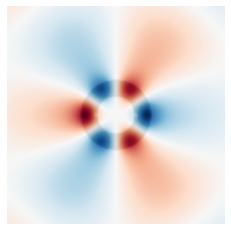

In [7]:
eps_data = sim.get_array(vol=nonpml_vol, component=mp.Dielectric)
ez_data = np.real(sim.get_dft_array(dft_obj, mp.Ez, 0))

plt.figure()
plt.imshow(eps_data.transpose(), interpolation='spline36', cmap='binary')
plt.imshow(ez_data.transpose(), interpolation='spline36', cmap='RdBu', alpha=0.9)
plt.axis('off')
plt.show()